# Analysis of Energy expectation values

This notebook is in response to the following question.

On 27 Jun 2016 04:54 -0700, Christiane Koch wrote:
> Eine Frage zum QSL: Levitin und Toffoli haben gezeigt, dass für
Zustände mit E=\Delta E die QSL-Schranke erreicht wird (PRL 103,
160502 (2009)). Kannst Du bitte E und \Delta E für die Dynamik der
logischen Zustände plotten? Wenn das für unsere Dynamik am QSL so
eins zu eins zutrifft (und eben nicht zutrifft bei längeren
Gatterdauern), wäre das noch ein schöner Beweis, dass wir das QSL
tatsächlich identifiziert haben.

Note: This notebook relies on a more recent version of QDYN/qdynpylib than the rest of this project

In [1]:
from sh import qdyn_prop_traj

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
qdyn_prop_traj('-v', _ok_code=[0,1])

QDYN 2.0dev revision 3cefb94e057b86ec51547043f6e69e4c5eb4d8ab (master)
  features: no-check-cheby, no-check-newton, no-parallel-ham, no-parallel-oct, backtraces
  compiled with gfortran on Mon Jul  4 16:02:04 2016 on host mlhpc2

In [5]:
rf_in = './propagate_universal/rho/H_L/'

In [32]:
rf_in = './liouville_prop/stage3/010/'

## Construction of the model

In [33]:
import QDYN

In [34]:
import numpy as np

In [35]:
import re, os

In [36]:
import scipy.sparse

In [37]:
H0 = QDYN.io.read_indexed_matrix(rf_in+'/ham_drift.dat') # GHz

In [38]:
H0.data = np.real(H0.data) # get rid of the decay term

In [39]:
H1 = QDYN.io.read_indexed_matrix(rf_in+'/ham_ctrl.dat') # iu

In [40]:
pulse = QDYN.pulse.Pulse.read(rf_in+'/pulse.dat')

In [41]:
psi = {}
psi['00'], psi['01'], psi['10'], psi['11'] = np.genfromtxt(rf_in+'/logical_states.dat', unpack=True, usecols=[0,1,2,3])

In [42]:
def get_w_d(config):
    with open(config) as in_fh:
        for line in in_fh:
            if 'w_d' in line:
                return QDYN.units.UnitFloat.from_str(
                        re.findall('([\d.Ee+-]+_\w+)', line)[0]) \
                       .convert('GHz')


In [43]:
def get_rwa_vector(config):
    from QDYN.config_conversion import read_old_config
    n_qubit = read_old_config(config)['user_ints'][0]['n_qubit']
    n_cavity = read_old_config(config)['user_ints'][0]['n_cavity']
    w_d  = get_w_d(config)
    n = n_qubit * n_qubit * n_cavity
    rwa_vector = np.zeros(n)
    for i in range(n_qubit):
        for j in range(n_qubit):
            for k in range(n_cavity):
                level_index = i * n_qubit * n_cavity  + j * n_cavity + k
                rwa_vector[level_index] = float(i+j+k) * float(w_d)
    return rwa_vector, w_d.unit

In [44]:
rwa_vector, rwa_unit = get_rwa_vector(rf_in+'/config')

In [45]:
H0_LAB = H0 + scipy.sparse.diags(rwa_vector, 0) # GHZ

In [46]:
for state in ['00', '01', '10', '11']:
    rf = './energy_run/%s' % state
    model = QDYN.model.LevelModel()
    model.add_ham(H0, op_unit='GHz', sparsity_model='indexed')
    model.add_ham(H1, pulse=pulse, op_unit='iu', sparsity_model='indexed')
    model.set_propagation(psi[state], T=pulse.T, nt=len(pulse.amplitude)+1,
                          time_unit=pulse.T.unit, prop_method='newton')
    model.add_observable(H0_LAB, 'energy.dat', 'GHz', 'ns', '<H0_LAB>', square='<H0_LAB^2>', is_real=True)
    model.write_to_runfolder(rf)
    np.savetxt(os.path.join(rf, 'rwa_vector.dat'), rwa_vector, header=('rwa_vector [%s]' % rwa_unit))

## Propagation

In [47]:
from sh import qdyn_prop_traj

In [48]:
qdyn_prop_traj = qdyn_prop_traj.bake(debug=True)

In [49]:
for state in ['00', '01', '10', '11']:
    rf = './energy_run/%s' % state
    qdyn_prop_traj(rf)

In [50]:
def get_energy_exp(rf):
    exp_vals = {}
    exp_vals['time [ns]'], \
    exp_vals['<H0_LAB> [GHz]'], exp_vals['<H0_LAB^2> [GHz^2]'], \
    = np.genfromtxt(rf+'/energy.dat', unpack=True)
    tgrid = exp_vals['time [ns]']
    E = exp_vals['<H0_LAB> [GHz]']
    varE = np.sqrt(exp_vals['<H0_LAB^2> [GHz^2]'] - E**2)
    return tgrid, E, varE

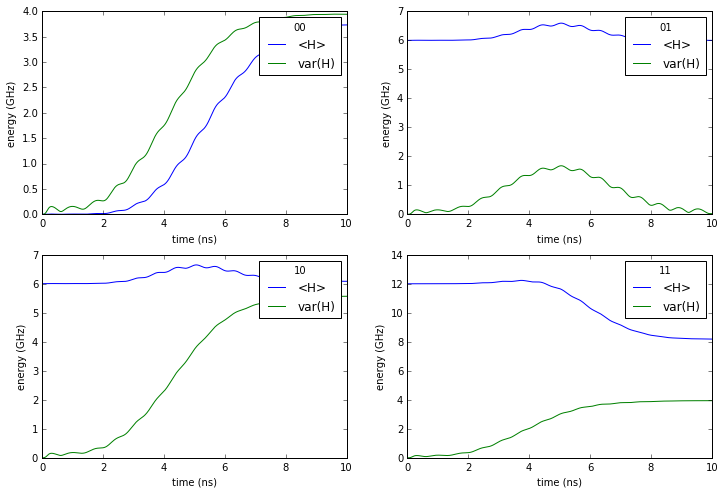

In [51]:
fig = plt.figure(figsize=(12,8))
for i_ax, state in enumerate(['00', '01', '10', '11']):
    rf = './energy_run/%s' % state
    ax = fig.add_subplot(2,2,i_ax+1)
    tgrid, E, varE = get_energy_exp(rf)
    ax.plot(tgrid, E, label='<H>')
    ax.plot(tgrid, varE, label='var(H)')
    ax.legend(loc='upper right', title=state)
    ax.set_xlabel("time (ns)")
    ax.set_ylabel("energy (GHz)")